In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
topics_df = pd.read_csv('bertopic_results_with_topics.csv')
#print(topics_df.head())

/var/folders/n3/kz2gn60507b7b477xltg2qpc0000gn/T/ipykernel_54428/4057745550.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  topics_df = pd.read_csv('bertopic_results_with_topics.csv')


In [4]:
text_blob_df = pd.read_csv('data/sentiment_analysis_textblob.csv')

In [6]:
text_blob_df_no_topic = text_blob_df.drop('topic', axis=1)

text_blob_df = text_blob_df_no_topic.merge(
    topics_df[['filename', 'title', 'chunk_id', 'topic']], 
    on=['filename', 'title', 'chunk_id'], 
    how='left')

print(text_blob_df.columns)

Index(['filename', 'source_type', 'source_name', 'title', 'publish_date',
       'chunk_id', 'text', 'probability', 'sentiment', 'sentiment_score',
       'subjectivity_score', 'subjectivity', 'topic'],
      dtype='object')


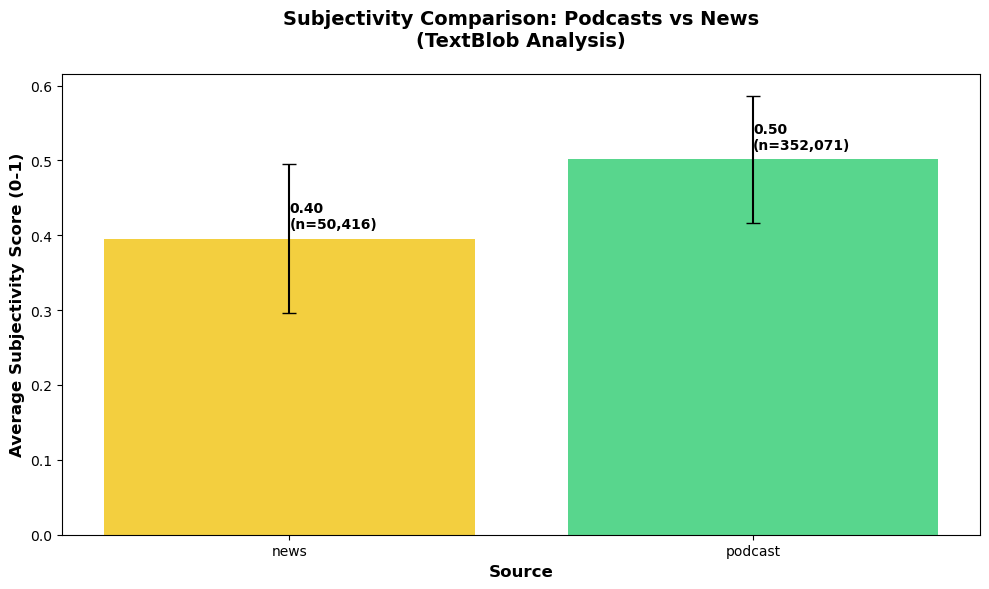

In [ ]:
def create_subjectivity_bar(df):

    source_subjectivity = df.groupby('source_type')['subjectivity_score'].agg(['mean', 'std', 'count']).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(source_subjectivity['source_type'], 
                  source_subjectivity['mean'],
                  yerr=source_subjectivity['std'],
                  capsize=5,
                  color=['#f1c40f', '#2ecc71'],
                  alpha=0.8,
                  edgecolor='none',
                  linewidth=1)

    ax.set_xlabel('Source', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Subjectivity Score (0-1)', fontsize=12, fontweight='bold')
    ax.set_title('Subjectivity Comparison: Podcasts vs News\n(TextBlob Analysis)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.tick_params(axis='both', which='major', labelsize=10)

    for bar, mean_val, count in zip(bars, source_subjectivity['mean'], source_subjectivity['count']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{mean_val:.2f}\n(n={count:,})',
                ha='left', va='bottom', fontweight='bold')
    

    plt.tight_layout()
    plt.show()

create_subjectivity_bar(text_blob_df)
    

In [18]:

def get_highest_prob_word(topic_list):
    if not topic_list or topic_list == '[]' or pd.isna(topic_list):
        return None
    
    
    if isinstance(topic_list, str):
        try:
            topic_list = eval(topic_list)
        except:
            return None
    
    if topic_list:
        max_tuple = max(topic_list, key=lambda x: x[1])
        return max_tuple[0]  
    
    return None

text_blob_df['topic_word'] = text_blob_df['topic'].apply(get_highest_prob_word)

In [22]:
topic_col = 'topic_word'
sub_by_topic = text_blob_df.groupby([topic_col, 'subjectivity']).size().unstack(fill_value=0)
sub_percentages = sub_by_topic.div(sub_by_topic.sum(axis=1), axis=0) * 100

topic_counts = text_blob_df[topic_col].value_counts()
sub_percentages = sub_percentages.reindex(topic_counts.index)

print("Subjectivity percentages by topic:")
print(sub_percentages.head())

Subjectivity percentages by topic:
subjectivity        high        low
purdue         44.444444  55.555556
ocho           50.000000  50.000000
fanduel        87.500000  12.500000
biden         100.000000   0.000000
black          71.428571  28.571429


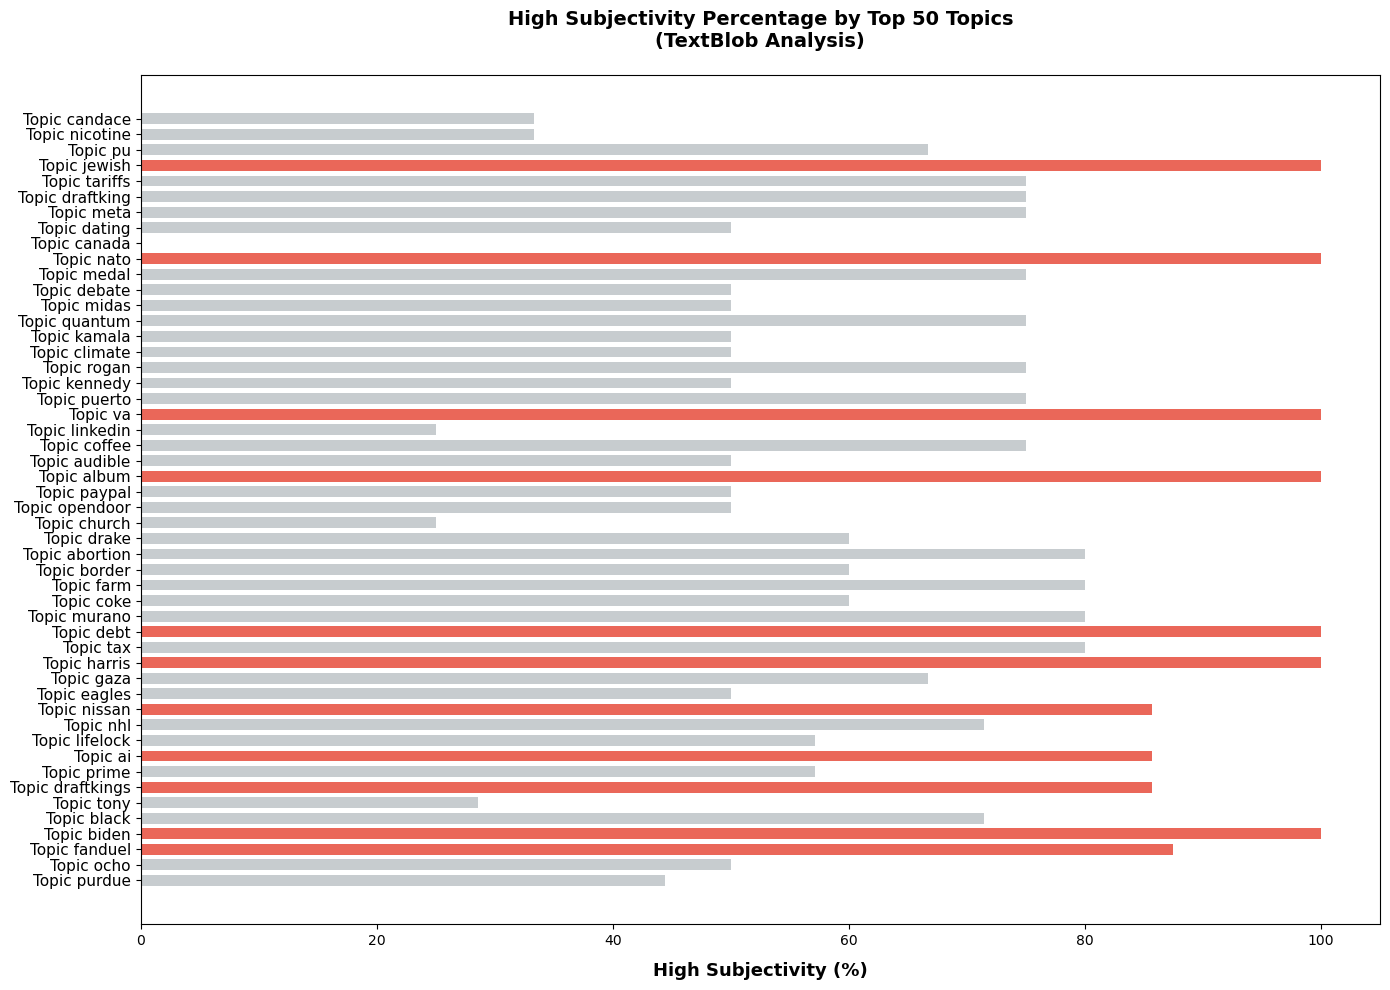

In [ ]:
def create_subjectivity_stacked_bar(data, max_topics=50):

    data = data.head(max_topics)
    
    fig, ax = plt.subplots(figsize=(14, 10))

    high = data.get('high', pd.Series(0, index=data.index))

    y_pos = np.arange(len(data.index))

    colors = ['#e74c3c' if val > 85 else '#bdc3c7' for val in high]

    bars = ax.barh(y_pos, high, color=colors, alpha=0.85, height=0.7)

    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"Topic {idx}" for idx in data.index], fontsize=11, fontweight='500')
    ax.set_xlabel('High Subjectivity (%)', fontsize=13, fontweight='bold', labelpad=10)
    ax.set_title('High Subjectivity Percentage by Top 50 Topics\n(TextBlob Analysis)', fontsize=14, fontweight='bold', pad=20)
    

    plt.tight_layout()
    plt.show()
    
create_subjectivity_stacked_bar(sub_percentages)
    


    